In this tutorial, we will explore the implementation of ARIMA model using python. 

#Data preprocessing

First, the necessary libraries are loaded.

In [1]:
!pip install -q sktime 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm
from sktime.utils.plotting import plot_series

The data set being used, *GlobalLandTemperatures*, is downloaded from [data.world](https://data.world/).
The variable 'LandAverageTemperature' was chosen as response variable.
First, we have to preprocess the data by removing nan values and extracting the 200 latest statistics.

In [3]:
# the dataset was uploaded to pastebin.com

DATA_URL = 'https://pastebin.com/raw/byX6Hsb8'

data = pd.read_csv(DATA_URL)[['LandAverageTemperature', 'dt']]
data.dropna(inplace=True)

data.set_index("dt", inplace=True)
data.index = pd.to_datetime(data.index)

data = data.tail(200)

y_no_period = data['LandAverageTemperature']
data.index = data.index.to_period("M")

We convert the time values from type "base" to type "period" and define y as the 'LandAverageTemperature' variable.

In [4]:
y = data['LandAverageTemperature']
y

dt
1999-05    11.706
1999-06    14.031
1999-07    14.853
1999-08    14.348
1999-09    12.723
            ...  
2015-08    14.755
2015-09    12.999
2015-10    10.801
2015-11     7.433
2015-12     5.518
Freq: M, Name: LandAverageTemperature, Length: 200, dtype: float64

Let's now plot the time series to get a better interpretation of it:

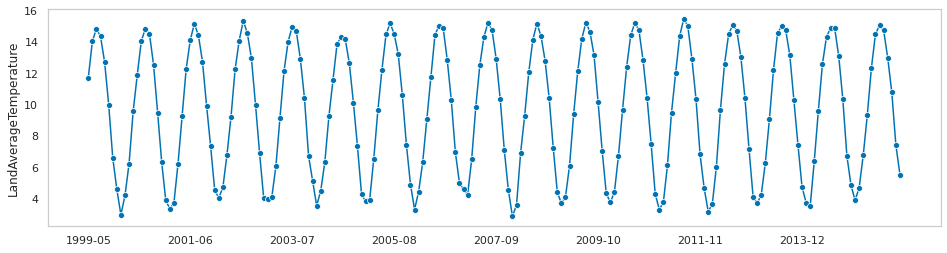

In [5]:
plot_series(y);

Additionally, we use seasonal_decompose from statsmodels to quickly plot the series decomposed into trend, seasonal and residual parts

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

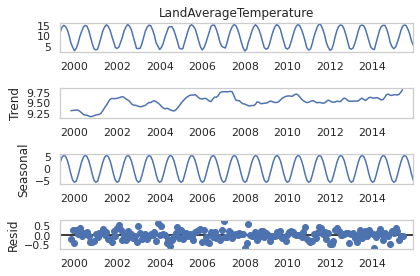

In [7]:
# Perform additive decomposition
decomp = seasonal_decompose(y_no_period, period=12)

# Plot decomposition
decomp.plot()
plt.show()

#Evaluation of a specific ARIMA model

In [8]:
# sklearn, statsmodels, sktime
!pip install -q pmdarima # автоматически выбирает ARIMA

We move on to import functions from sktime library that will be later applied. 

In [9]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

In order to appropriately fit a model, it has to be trained on the training data set first, and then its performance will be evaluated with test set. We've defined the test set to be the last 36 observations in y, and train to be the first, because in time series our goal is to predict future outcomes with the knowledge of information in the past.

In [10]:
y_train, y_test = temporal_train_test_split(y, test_size=36)

Let's visualize the training and test observations:

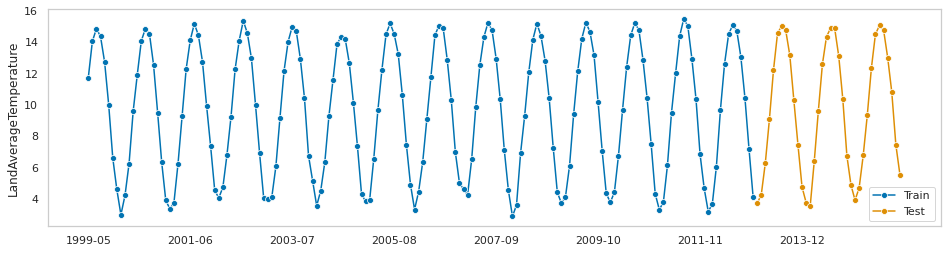

In [11]:
plot_series(y_train, y_test, labels=['Train', 'Test']);

Now we have everything needed to fit the model! One last step: in sktime, the model does not make predictions based on the indexes(time values) of *y_test*. Rather, they are required to be first converted into the so-called *horizon*. This can be easily done with *ForecastingHorizon* function:

In [12]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh_train = ForecastingHorizon(y_train.index, is_relative=False)

Now we move on to the actual ARIMA model.To start with, we will pick an ARIMA model and demonstrate the full fitting process on it. Basically, in order to choose a more suitable model, we have to decide on which parameters to use. By purely looking at the graph, it can be seen that clear seasonality exists, so we can assume that seasonal ARIMA should be applied. The parameters in a seasonal ARIMA, $ARIMA(p,d,q)(P,D,Q,m)$ are as follows:

$p$ - number of estimated coefficients in non-seasonal AR part

$d$ - number of transitions to non-seasonal difference

$q$ - number of estimated coefficients in non-seasonal MA part

$P$ - number of estimated coefficients in seasonal AR 

$D$ - number of transitions to seasonal difference

$Q$ - number of estimated coefficients in seasonal MA part

$m$ - seasonality period

We will first examine the stationarity of data set with Dicki Fuller's test:

In [13]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(y)
pvalue, usedlag_

(0.03791941165420691, 15)

The obtained p-value is less than 5% => the data is stationary, and there is no need to take non-seasonal difference since no trend is present in the data($d = 0$). In addition, it is apparent that $m=12$ from the time series graph and the decomposed series graph.

Next, we determine the rest of parameters via ACF and PACF plots with the following decision rule:

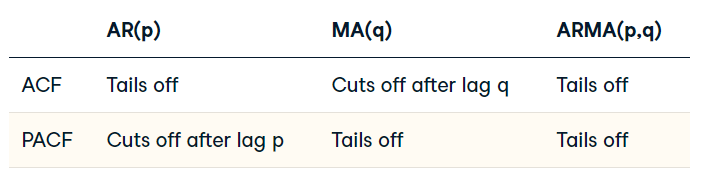

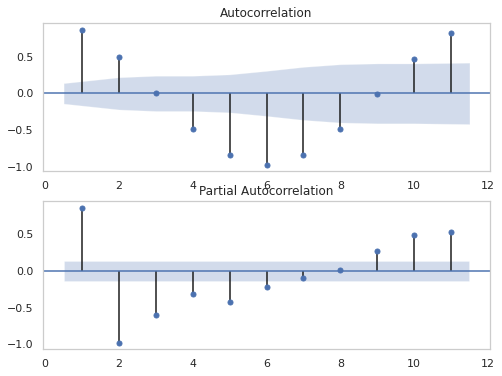

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(y,lags=11,zero=False,ax=ax1)

# Plot the PACF on ax2
plot_pacf(y,lags=11,zero=False,ax=ax2)

plt.show()

Both the non-seasonal ACF and PACF tail off, and it is not possible to deduce which parameters are optimal to choose from the plots. What about the seasonal part?

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


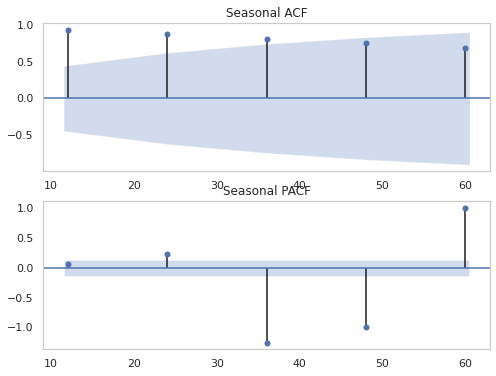

In [15]:
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(y,lags=lags,zero=False,ax=ax1,title="Seasonal ACF")

# Plot the PACF on ax2
plot_pacf(y,lags=lags,zero=False,ax=ax2,title="Seasonal PACF")

plt.show()

Oops, the seasonal ACF are high and tails off very slowly, which is an evidence of non-stationarity. Let's take the first seasonal difference and see how it works: 

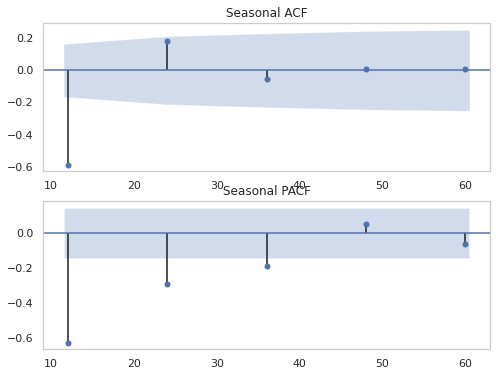

In [16]:
y_diff = y.diff(12).dropna()
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(y_diff,lags=lags,zero=False,ax=ax1,title="Seasonal ACF")

# Plot the PACF on ax2
plot_pacf(y_diff,lags=lags,zero=False,ax=ax2,title="Seasonal PACF")

plt.show()

Now it looks like our data is stationary, and the seasonal ACF cuts off after lag 1, thus the seasonal parameters can be chosen as: $P = 0, D=1, Q=1$ and $m=12$.

We convert the time values from type "base" to type "period" and define y as the 'LandAverageTemperature' variable.

We still have to decide on non-seasonal parameters. To make a good guess, we will fit a few ARIMA models by iterating through several values of p and q, and measure their performance by the smape loss([Symmetric mean absolute percentage error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)) :


$$smape = \frac{1}{H} \sum_{i = T+1}^{T+H} \frac{|y_i - \hat y_i|}{(|y_i| + |\hat y_i|)/2}$$

In [17]:
from sktime.performance_metrics.forecasting import smape_loss

In [18]:
order_smape = []

for p in tqdm(range(4)):
  for q in range(4):
    forecaster = ARIMA(
        order=(p, 0, q), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)
    fc_fit = forecaster.fit(y_train)

    y_pred = forecaster.predict(fh_train)
    smape_train = smape_loss(y_train, y_pred)

    y_pred = forecaster.predict(fh)
    smape_test = smape_loss(y_test, y_pred)
    order_smape.append((p,q,smape_train, smape_test))

In [19]:
order_df = pd.DataFrame(order_smape, columns=['p','q','smape train', 'smape test'])
order_df = order_df.sort_values('smape test')
order_df.head()

,p,q,smape train,smape test
0,0,0,0.182569,0.030270
1,0,1,0.183024,0.030807
4,1,0,0.182644,0.031478
6,1,2,0.181229,0.031725
5,1,1,0.181744,0.031895


p and q equal to 0 and 0 give the best error value on the validation set

0.03027039523256432

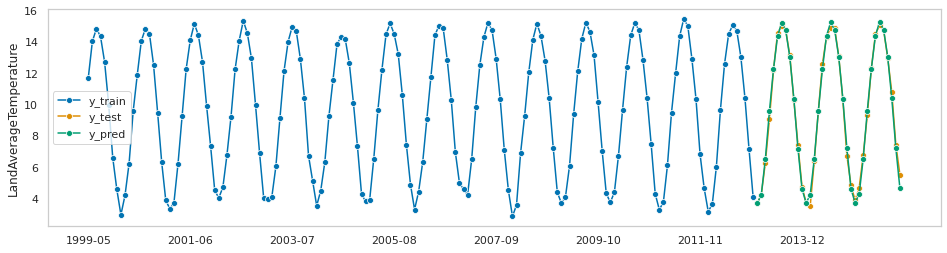

In [20]:
forecaster = ARIMA(
        order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)
fc_fit = forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

We can obtain more information with the summary function:

In [21]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  164
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                 -45.702
Date:                    Wed, 03 Feb 2021   AIC                             97.405
Time:                            16:16:28   BIC                            106.477
Sample:                                 0   HQIC                           101.090
                                    - 164                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0192      0.006      3.018      0.003       0.007       0.032
ma.S.L12      -0.9456      0.218     -4.342      0.000      -1.372      -0.519
sigma2         0.0912      0.019      4.790      0.000       0.054       0.129
===================================================================================
Ljung-Box (L1) (Q):                  13.70   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.00   Prob(JB):                         0.40
Heteroskedasticity (H):               0.65   Skew:                            -0.11
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary table tells us that the model is of form

$$
(1-L^{12})y_t = 0.0192-0.9456L^{12}u_t
$$

#III. Automatic selection of the best ARIMA model

In this section, we implement the built-in *AutoARIMA* function, which automatically selects the best ARIMA model based on AIC criterion(by default). In *AutoARIMA* there is a wide variety of parameters to tune. For simplicity, we only specified *sp*, the period for seasonal differencing, to 12. We fitted the model and plotted the prediction graph:

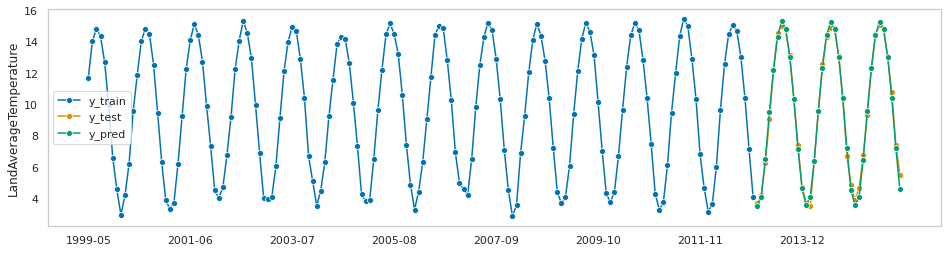

In [22]:
auto_forecaster = AutoARIMA(sp=12, suppress_warnings=True)
auto_forecaster.fit(y_train)
y_pred = auto_forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

The graph depicts an almost flawless prediction! Let's derive the smape loss of automatically selected model:

In [23]:
smape_loss(y_test, y_pred)

0.03496191897717126

We can again obtain more information with the summary function:

In [24]:
auto_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  164
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -29.132
Date:                            Wed, 03 Feb 2021   AIC                             72.263
Time:                                    16:17:50   BIC                             93.431
Sample:                                         0   HQIC                            80.862
                                            - 164                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0226      0.014      1.663      0.096      -0.004       0.049
ar.L1         -0.3787      0.157     -2.410      0.016      -0.687      -0.071
ar.L2          0.4289      0.068      6.274      0.000       0.295       0.563
ma.L1          0.7028      0.170      4.132      0.000       0.369       1.036
ar.S.L12      -0.2984      0.100     -2.981      0.003      -0.495      -0.102
ma.S.L12      -0.7885      0.125     -6.313      0.000      -1.033      -0.544
sigma2         0.0763      0.008      9.014      0.000       0.060       0.093
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.92   Prob(JB):                         0.40
Heteroskedasticity (H):               0.69   Skew:                             0.22
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary table tells us that the model is of form

$$(1-(-0.3225)L^{12})(1-(-0.3845)L-0.4262L^2)(1-L^{12})y_t = 0.0242+(1+0.7028L)(1+(-0.773)L^{12})u_t$$

Also, we can conclude that although the smape_loss of AutoARIMA model is greater than the manually specified ARIMA model, its AIC value is smaller than the latter, which is reasonable since we chose to optimize by AIC criterion.

And the 95% confidence interval:

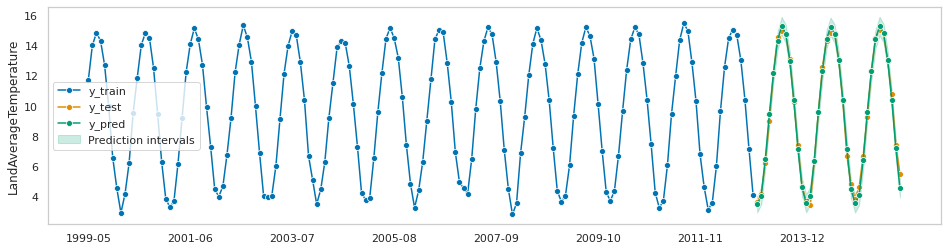

In [25]:
alpha=0.05
y_pred, pred_ints = auto_forecaster.predict(fh, return_pred_int=True, alpha=alpha)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

plt.fill_between(
    range(len(y) - len(y_test), len(y)),
    pred_ints['lower'],
    pred_ints['upper'],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label='Prediction intervals',
)


plt.legend();

# IV. Comparison of models

We will use a sliding window technique to compare the ARIMA models. In particular, we will choose p and q such that smape is minimal.

In [26]:
def get_windows(data, window_length=36, test_length=2):
    res = [] # [(y_train, y_test)]
    for i in range(0, len(data)-window_length-test_length+1):
        y_train = data[i:i+window_length]
        y_test = data[i+window_length:i+window_length+test_length]
        e = (y_train, y_test)
        res.append(e)
    return res

In [27]:
windows = get_windows(y)[:25] # takes too much time otherwise

In [ ]:
order_smape = []

for p in tqdm(range(4)):
  for q in tqdm(range(4)):
      for w_train, w_test in windows:
        forecaster = ARIMA(
            order=(p, 0, q), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)
        fc_fit = forecaster.fit(w_train)

        w_fh = ForecastingHorizon(w_test.index, is_relative=False)
    
        w_pred = forecaster.predict(w_fh)
        smape_test = smape_loss(w_test, w_pred)

        order_smape.append((p,q, smape_test))

In [ ]:
order_df = pd.DataFrame(order_smape, columns=['p','q','smape'])

We are calculating average of smap errors for each pair of p and q

In [ ]:
order_df.groupby(['p', 'q']).mean().reset_index().sort_values('smape', ascending=False)

Based on the table above, the optimal p and q are 0 and 1 respectively.

#5.

TODO